## Import modules

In [55]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor as Tensor
from numpy import ndarray as ndarray
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rangeBias = 15*sqrt(3) / 8

## Define the functions

$$
\begin{align*}
    f(x)  &=  \frac{1}{1 + 25x^2} \\
    f'(x) &= -\frac{50x}{(1 + 25x^2)^2}
\end{align*}
$$

In [56]:
def runge(x: float) -> float:
    return 1 / (1 + 25 * x**2)

def runge_diff(x: float) -> float:
    return -50*x / (1 + 25 * x**2)**2

## Prepare data

In [57]:
class DataSet:
    def __init__(
        self,
        _dataNum: int,
        _delta  : float,
        _sigma: float
    ) -> None:
        
        self.dataNum: int   = _dataNum
        self.delta  : float = _delta
        self.sigma  : float = _sigma

        self.x        : ndarray = np.random.uniform(-1, 1, _dataNum).reshape(-1, 1)
        self.x_left   : ndarray = self.x - _delta
        self.x_right  : ndarray = self.x + _delta
        self.y_rl     : ndarray = runge(self.x)
        self.y_diff_rl: ndarray = runge_diff(self.x)
        self.y        : ndarray = self.y_rl      + np.random.normal(0, _sigma, _dataNum).reshape(-1, 1)
        self.y_diff   : ndarray = self.y_diff_rl + np.random.normal(0, _sigma*rangeBias, _dataNum).reshape(-1, 1)

        self.x_t        : Tensor = torch.tensor(self.x,         dtype=torch.float32)
        self.x_left_t   : Tensor = torch.tensor(self.x_left,    dtype=torch.float32)
        self.x_right_t  : Tensor = torch.tensor(self.x_right,   dtype=torch.float32)
        self.y_rl_t     : Tensor = torch.tensor(self.y_rl,      dtype=torch.float32)
        self.y_diff_rl_t: Tensor = torch.tensor(self.y_diff_rl, dtype=torch.float32)
        self.y_t        : Tensor = torch.tensor(self.y,         dtype=torch.float32)
        self.y_diff_t   : Tensor = torch.tensor(self.y_diff,    dtype=torch.float32)
        self.y_cat_t    : Tensor = torch.cat((self.y_t, self.y_diff_t/rangeBias), dim=0)

delta = 0.001
sigma = 0.05

trainData = DataSet(800, delta, sigma)
validData = DataSet(100, delta, sigma)
testData  = DataSet(100, delta, sigma)

## Design the Network

In [58]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.seq(x)

## Training epoch

 Epoch | trainLoss | validLoss 
-------|-----------|-----------
     0 |  0.189130 |  0.181010 
   100 |  0.003185 |  0.003687 
   200 |  0.002509 |  0.002765 
   300 |  0.002490 |  0.002741 
   400 |  0.002483 |  0.002727 
   500 |  0.002479 |  0.002715 
   600 |  0.002475 |  0.002704 
   700 |  0.002472 |  0.002696 
   800 |  0.002470 |  0.002688 
   900 |  0.002469 |  0.002682 

Final loss: 0.002467


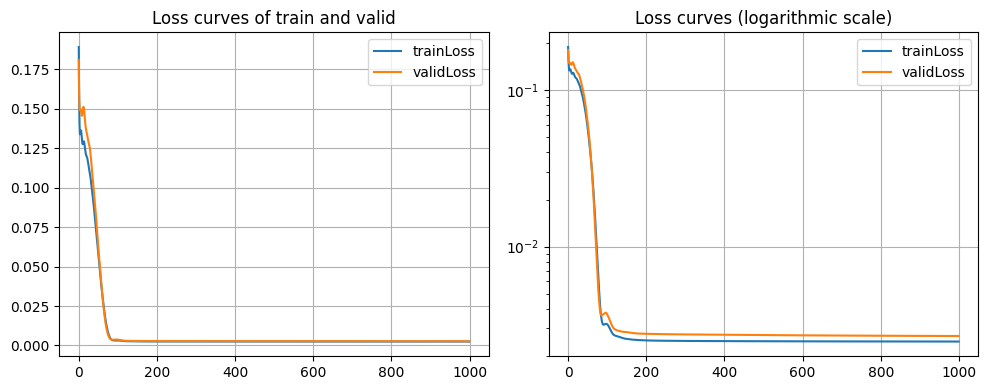

In [59]:
net       = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

trainEpoch    = 1000
epochlist     = np.arange(trainEpoch)
trainlosslist = []
validlosslist = []

print(" Epoch | trainLoss | validLoss ")
print("-------|-----------|-----------")

for epoch in range(trainEpoch):
    optimizer.zero_grad()

    # train data
    y_pred       = net(trainData.x_t)
    y_pred_left  = net(trainData.x_left_t)
    y_pred_right = net(trainData.x_right_t)
    diff_pred    = (y_pred_right - y_pred_left) / (2 * trainData.delta)
    trainloss    = criterion(torch.cat((y_pred, diff_pred/rangeBias), dim=0), trainData.y_cat_t)

    trainloss.backward()
    optimizer.step()

    # test data
    y_valid       = net(validData.x_t)
    y_valid_left  = net(validData.x_left_t)
    y_valid_right = net(validData.x_right_t)
    diff_valid    = (y_valid_right - y_valid_left) / (2 * validData.delta)
    validloss     = criterion(torch.cat((y_valid, diff_valid/rangeBias), dim=0), validData.y_cat_t)

    trainlosslist.append(trainloss.item())
    validlosslist.append(validloss.item())
    
    if epoch % 100 == 0:
        print(" {0:5d} | {1:9.6f} | {2:9.6f} ".format(epoch, trainloss.item(), validloss.item()))

print("\nFinal loss: {0:.6f}".format(trainlosslist[-1]))

fig1, axes1 = plt.subplots(1, 2, figsize=(10, 4))

axes1[0].plot(epochlist, trainlosslist, label='trainLoss')
axes1[0].plot(epochlist, validlosslist, label='validLoss')
axes1[0].legend()
axes1[0].grid(True)
axes1[0].set_title("Loss curves of train and valid")

axes1[1].plot(epochlist, trainlosslist, label='trainLoss')
axes1[1].plot(epochlist, validlosslist, label='validLoss')
axes1[1].set_yscale('log')
axes1[1].legend()
axes1[1].grid(True)
axes1[1].set_title("Loss curves (logarithmic scale)")

plt.tight_layout()
plt.show()

## Result display

test valueloss: 0.000023
test diffloss : 0.000372


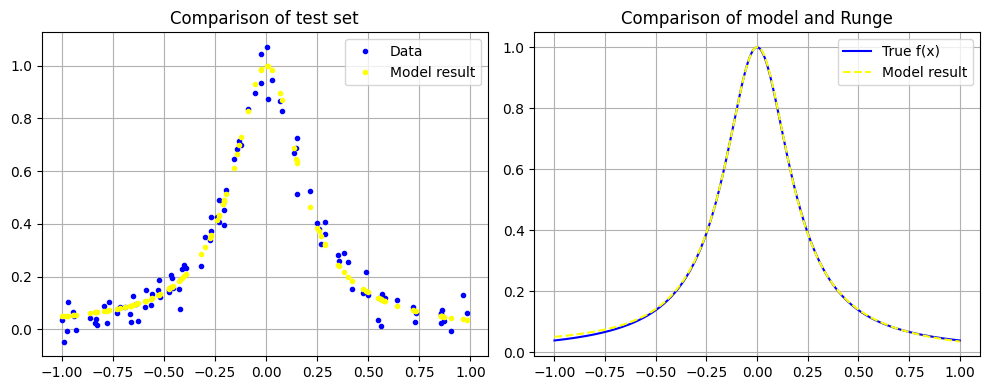

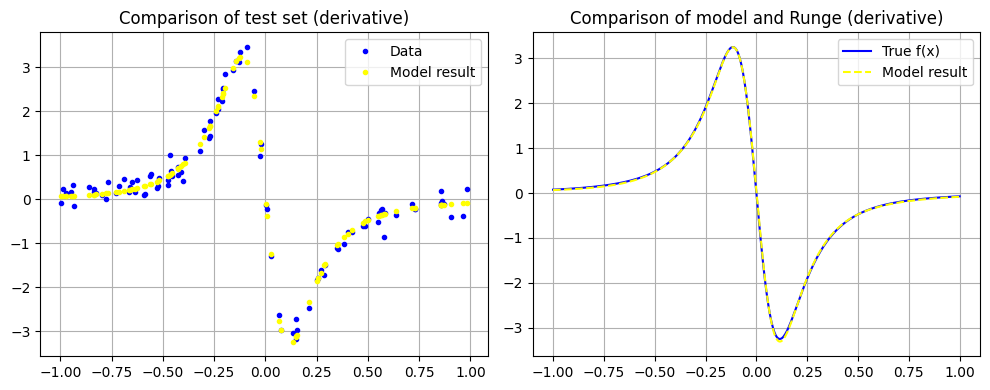

In [61]:
y_pred       = net(testData.x_t)
y_pred_np    = y_pred.detach().numpy()
y_pred_left  = net(testData.x_left_t)
y_pred_right = net(testData.x_right_t)
diff_pred    = (y_pred_right - y_pred_left) / (2 * testData.delta)
diff_pred_np = diff_pred.detach().numpy()
valueloss    = criterion(y_pred,    testData.y_rl_t)
diffloss     = criterion(diff_pred, testData.y_diff_rl_t)

print("test valueloss: {0:.6f}".format(valueloss))
print("test diffloss : {0:.6f}".format(diffloss))

# display function result
x_axis   = np.linspace(-1, 1, 500).reshape(-1, 1)
x_axis_t = torch.tensor(x_axis, dtype=torch.float32)
y_runge  = runge(x_axis)
y_net    = net(x_axis_t).detach().numpy()

fig2, axes2 = plt.subplots(1, 2, figsize=(10, 4))

axes2[0].plot(testData.x, testData.y, '.', color='blue',   label='Data')
axes2[0].plot(testData.x, y_pred_np,  '.', color='yellow', label='Model result')
axes2[0].legend()
axes2[0].grid(True)
axes2[0].set_title("Comparison of test set")

axes2[1].plot(x_axis, y_runge, color='blue',   label='True f(x)')
axes2[1].plot(x_axis, y_net,   color='yellow', label='Model result', linestyle='--')
axes2[1].legend()
axes2[1].grid(True)
axes2[1].set_title("Comparison of model and Runge")

plt.tight_layout()
plt.show()

# display diff result
y_diff_runge  = runge_diff(x_axis)
y_net_left    = net(x_axis_t - delta)
y_net_right   = net(x_axis_t + delta)
y_diff_net_np = ((y_net_right - y_net_left) / (2 * delta)).detach().numpy()

fig3, axes3 = plt.subplots(1, 2, figsize=(10, 4))

axes3[0].plot(testData.x, testData.y_diff, '.', color='blue',   label='Data')
axes3[0].plot(testData.x, diff_pred_np,    '.', color='yellow', label='Model result')
axes3[0].legend()
axes3[0].grid(True)
axes3[0].set_title("Comparison of test set (derivative)")

axes3[1].plot(x_axis, y_diff_runge,  color='blue',   label='True f(x)')
axes3[1].plot(x_axis, y_diff_net_np, color='yellow', label='Model result', linestyle='--')
axes3[1].legend()
axes3[1].grid(True)
axes3[1].set_title("Comparison of model and Runge (derivative)")

plt.tight_layout()
plt.show()